# Task 5: Modality Gap in CLIP


### Importing libraries


Importing the necessary libraries for the task.

In [1]:
import os
import torch
import numpy as np
import torchvision
import pathlib
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import tqdm
from torchmetrics import ConfusionMatrix, Precision, Recall, F1Score
from torch import nn

### Initializing Dataset

Specifying the directories in which the Office-Home data is stored.

In [ ]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"


The office-home dataset is used to evaluate domain adaptation algorithms, and consists of images from 4 different domains: Artistic images, Clip Art, Product images and Real-World images. For each domain, the dataset contains images of 65 object categories found typically in Office and Home settings https://www.hemanthdv.org/officeHomeDataset.html.

In [ ]:
from utils.dataset import OfficeHomeDataset

def get_domain_ds(domains):
    return OfficeHomeDataset(root_dir, csv_file, domains, None)


In [3]:
import random
import PIL 

def display(pil_image):
    plt.imshow(pil_image)
    plt.axis("off")     
    plt.tight_layout()
    plt.show()

In [ ]:
domains = ["Art", "Real World", "Product","Clipart"]
dataset = get_domain_ds(domains)
classes = dataset.classes
print("Classes: ", classes)

100%|██████████| 2.64G/2.64G [01:46<00:00, 24.9MB/s]


Classes:  ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


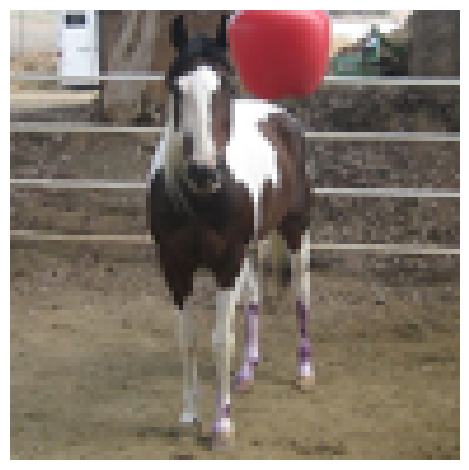

In [12]:
image, label = random.choice(dataset)
display(image)

### Downloading and Configuring the CLIP model

Here we import the clip-ViT-B-32 from https://github.com/openai/CLIP and it's corresponding preprocessing transform, 

In [9]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-l4i6lnlr
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-l4i6lnlr
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 

In [10]:
import clip
import random

model, preprocess = clip.load("ViT-B/32", device="cpu")

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 212MiB/s]


### Evaluating Prompting Strategies

Here we test how the zero-shot performance of the model on a few examples and try different prompting strategies. In the first cell, a number of utility functions are defined to help with analysis. 

In [ ]:
from sklearn.metrics import classification_report
import tqdm
from torchmetrics import ConfusionMatrix
import seaborn as sns

def analyze_sample(text:list[str], seed:int = 100):
    random.seed(seed)
    idx = random.randint(0, len(dataset)-1)
    pil_image, label = dataset[idx]
    label = dataset.classes[label]

    image = preprocess(pil_image).unsqueeze(0)
    text = clip.tokenize(text)

    with torch.no_grad():
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    print("True Label: ", label)
    print("Label probs: ", probs)
    display(pil_image)

def get_image_features(dataset:torch.utils.data.Dataset):
    all_features = []
    all_labels = []
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=os.cpu_count())
    with torch.no_grad():
        for images, labels in loader:
            features = model.encode_image(images)

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu(), torch.cat(all_labels).cpu()

def get_text_features(text: list[str]):
    with torch.no_grad():
        text = clip.tokenize(text)
        return model.encode_text(text).cpu()



def eval(image_features, text_features, all_labels):
    logits = image_features@text_features.T
    preds = logits.argmax(dim=-1).cpu().tolist()
    confmat = ConfusionMatrix(task="multiclass", num_classes=len(classes))
    print(classification_report(all_labels, preds))
    sns.heatmap(confmat(logits, all_labels), annot=True, cmap="Blues", xticklabels=classes, yticklabels=classes)

def eval_probe(preds, labels):
    confmat = ConfusionMatrix(task="multiclass", num_classes=len(classes))
    print(classification_report(labels, preds))
    sns.heatmap(confmat(preds, labels), annot=True, cmap="Blues", xticklabels=classes, yticklabels=classes)



    

True Label:  cat
Label probs:  [[0.00500698 0.03008347 0.04826371 0.7339477  0.02792943 0.02830261
  0.00608325 0.09085401 0.02003433 0.00949454]]


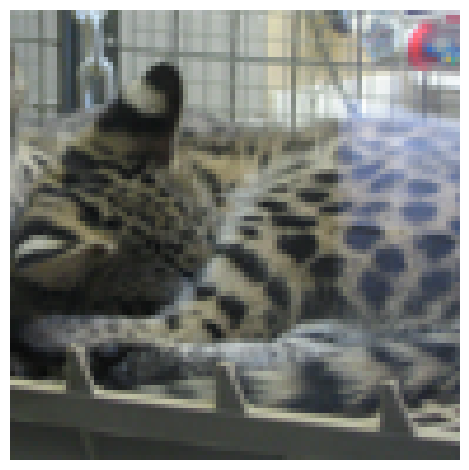

In [ ]:
classes = dataset.classes
analyze_sample(text=classes, seed=100)

In [ ]:
def combine_caches(caches):
    features, labels = zip(*caches)
    return torch.cat(features), torch.cat(labels).cpu()

def eval_cache(cache, prompts):
    image_features, labels = cache
    eval(image_features, prompts, labels)
    plt.show()

cache_store = {}
for domain in domains:
    cache_store[domain] = get_image_features( get_domain_ds(['domain']))


              precision    recall  f1-score   support

           0       1.00      0.74      0.85       500
           1       0.89      1.00      0.94       500
           2       0.99      0.95      0.97       500
           3       0.99      0.84      0.91       500
           4       0.96      0.96      0.96       500
           5       0.90      0.98      0.94       500
           6       0.95      0.99      0.97       500
           7       0.97      0.90      0.94       500
           8       0.82      1.00      0.90       500
           9       0.95      0.99      0.97       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.93      5000
weighted avg       0.94      0.94      0.93      5000



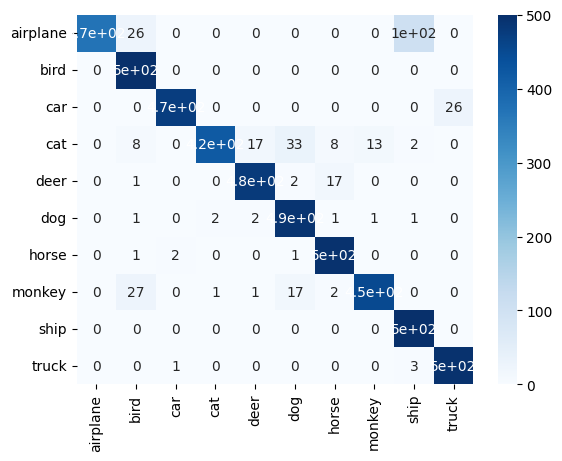

In [ ]:
prompts = get_text_features(classes)
for domain, cache in cache_store.items():
    print("Evaluating Zero-Shot on domain : {domain}")
    eval_cache(cache, prompts)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       500
           1       0.94      1.00      0.97       500
           2       0.97      0.99      0.98       500
           3       0.98      0.90      0.94       500
           4       0.97      0.94      0.96       500
           5       0.91      0.98      0.94       500
           6       0.94      0.99      0.97       500
           7       0.99      0.89      0.94       500
           8       0.96      1.00      0.98       500
           9       0.99      0.98      0.98       500

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



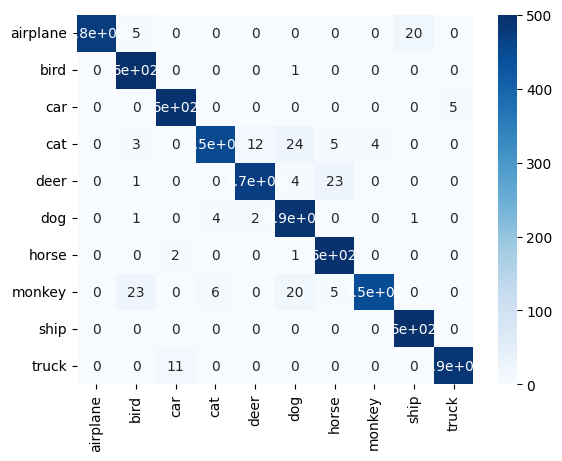

In [ ]:
prompts = get_text_features(["a "+ cls for cls in classes])
for domain, cache in cache_store.items():
    print("Evaluating Zero-Shot on domain : {domain} (with modified prompts)")
    eval_cache(cache, prompts)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       0.96      1.00      0.98       500
           2       0.96      0.99      0.98       500
           3       0.96      0.94      0.95       500
           4       0.97      0.96      0.97       500
           5       0.96      0.97      0.97       500
           6       0.95      0.99      0.97       500
           7       0.98      0.92      0.95       500
           8       0.99      0.99      0.99       500
           9       0.99      0.96      0.98       500

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



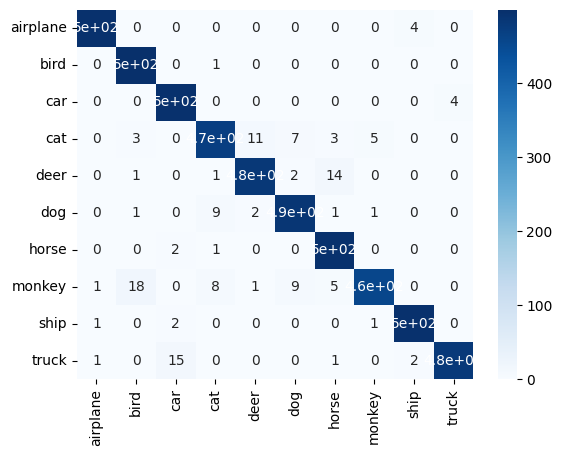

In [ ]:
for domain, cache in cache_store.items():
    print("Evaluating Zero-Shot on domain : {domain} (with modified prompts)")
    prompts = get_text_features(["a {domain} photo of "+ cls for cls in classes])
    eval_cache(cache, prompts)

### Evaluating CLIP accuracy on Image Features

In [ ]:
print("hello")

In [ ]:
from sklearn.linear_model import LogisticRegression

torch.manual_seed(100)

for domain in domains:
    features, labels = cache_store[domain]
    
    idx = torch.randperm(len(labels))
    features = features[idx]
    labels = features[idx]
    
    n = int(0.8 * len(features))

    train_features, train_labels = features[0:n], labels[0:n]
    test_features, test_labels = features[n:0], labels[n:0]

    classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
    classifier.fit(train_features, train_labels)

    predictions = classifier.predict(test_features)
  
    eval_probe(predictions, test_labels)

### Exploring the Modality Gap


In this section, we explore the modality gap in multi-modal embedding space of clip. We use 5000 examples from and umap for dimensionality reduction. 


In [56]:
import umap

epsilon = 0.01
def reduce_features(features:torch.tensor):
    clone = features.clone().detach()
    reduced = torch.tensor(umap.UMAP(n_neighbors=30, n_components=2).fit_transform(clone))
    return reduced

def visualize_map(image_features: torch.tensor, text_features: torch.tensor):

    X, Y  = image_features[:, 0], image_features[:, 1]
    plt.scatter(X, Y, c="r",label="Image features",
        alpha=0.6, edgecolors='k', marker="o")
    
    X, Y  = text_features[:, 0], text_features[:, 1]
    plt.scatter(X, Y, c="b",  label="Text features",
        alpha=0.6,  edgecolors='k', marker="^")

    plt.title("CLIP Feature Space (2D)")
    plt.xlabel("Feature dimension 1")
    plt.ylabel("Feature dimension 2")
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.show()

def plot_embedding_space(image_features: torch.tensor, text_features: torch.tensor):
    N = len(image_features)
    embeddings = torch.cat([image_features, text_features], dim=0)
    reduced = reduce_features(embeddings)
    visualize_map(reduced[:N], reduced[N:])



2025-09-08 09:34:38.157538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757324078.468790      72 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757324078.555538      72 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [57]:
class_embeddings = get_text_features(classes)

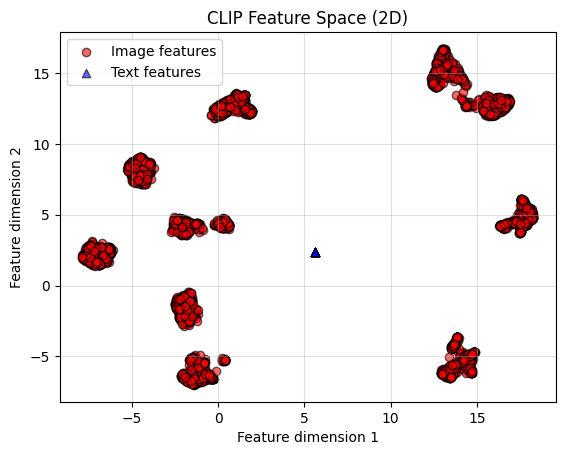

In [58]:
plot_embedding_space(features, class_embeddings)

As can be see above, the modality gap between image and text features is larger than one would have expected. Moreover all label embeddings are concentrated in a single region. Below we test text embeddings extracted from pinterest, similar to the data the model was trained on. We also try to visualize the multi-model embedding space after normalizing features.

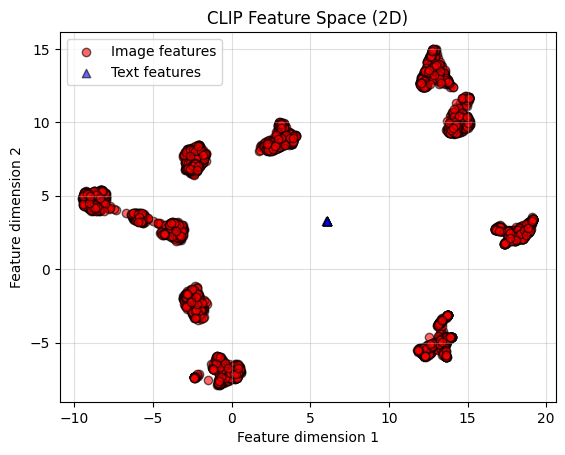

In [60]:
combined = torch.concat([features, class_embeddings], dim=0)
mean = combined.mean()
std = combined.std()
normalized = (combined-mean)/std
plot_embedding_space(normalized[:len(features)], normalized[len(features):])


In [311]:
import requests 
from bs4 import BeautifulSoup

url = 'https://www.pinterest.com/ideas/'
resp = requests.get(url)
soup = BeautifulSoup(resp.content, features="html.parser")

tags = soup.find_all('a')
captions = [tag.text for tag in tags]

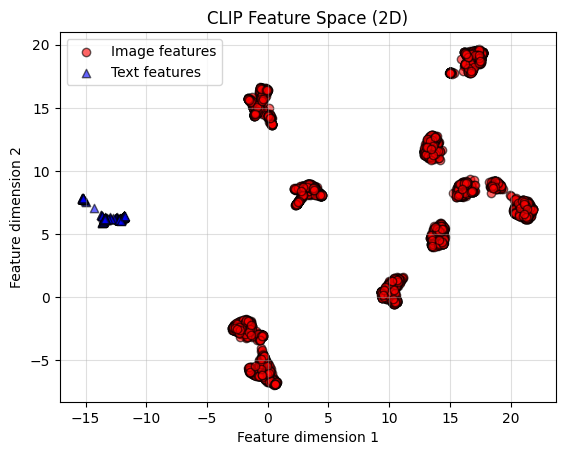

In [312]:
text_features = get_text_features(captions)
plot_embedding_space(features, text_features)

### Bridging the Modality Gap

In this section we try to align that modalities in multi-modal embedding space using the orthogonal procrustes transform.

In [69]:
from scipy.linalg import orthogonal_procrustes

text_embeddings = torch.stack([class_embeddings[i] for i in labels.tolist()], dim=0)
R, _ = orthogonal_procrustes(features, text_embeddings)
rotated_embeddings = features@R

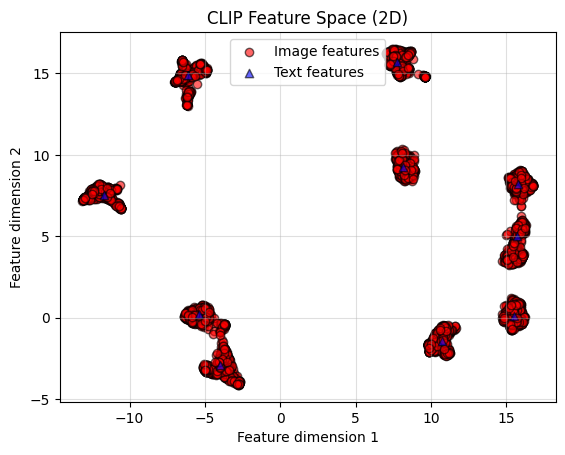

In [70]:
plot_embedding_space(rotated_embeddings, class_embeddings)

              precision    recall  f1-score   support

           0       1.00      0.80      0.89       500
           1       0.86      1.00      0.92       500
           2       1.00      0.96      0.98       500
           3       1.00      0.74      0.85       500
           4       1.00      0.77      0.87       500
           5       0.74      1.00      0.85       500
           6       0.96      0.99      0.97       500
           7       0.97      0.92      0.94       500
           8       0.81      1.00      0.90       500
           9       0.96      0.99      0.97       500

    accuracy                           0.92      5000
   macro avg       0.93      0.92      0.91      5000
weighted avg       0.93      0.92      0.91      5000



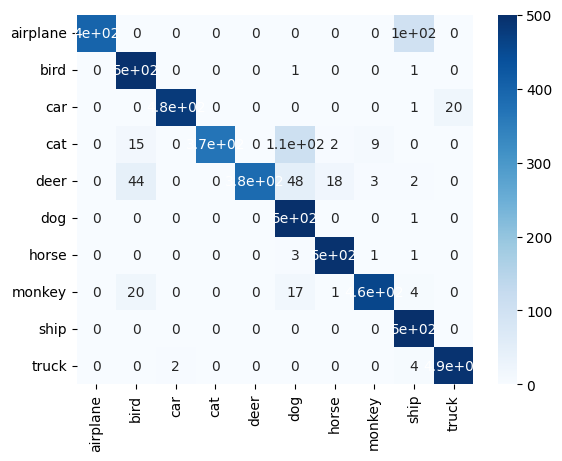

In [71]:
eval(rotated_embeddings, class_embeddings, labels)